## Import libs

Note:
*   import py does not work on Colab
*   confliction tf and torch versions for parsing and cp-vton-plus requirements

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os, sys
package_path = '/content/myPackage'
os.symlink('/content/drive/My Drive/Colab Notebooks', package_path)
sys.path.append(package_path)

%cd /content/drive/MyDrive/SMFAI/src


Mounted at /content/drive
/content/drive/MyDrive/SMFAI/src


In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import pickle
import torch
import shutil
import numpy as np
import pandas as pd
from utils import *
from PIL import Image

import torchvision
from IPython.core.display import Video
from moviepy.editor import *
import moviepy.video.fx.all as vfx
from moviepy.video.fx.all import crop, resize
import ffmpeg

import json
import argparse
import pickle
import random
import os
import subprocess

from tqdm import tqdm
from google.colab.patches import cv2_imshow

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3358720/45929032 bytes (7.3%)7446528/45929032 bytes (16.2%)11403264/45929032 bytes (24.8%)15466496/45929032 bytes (33.7%)19529728/45929032 bytes (42.5%)23691264/45929032 bytes (51.6%)27934720/45929032 bytes (60.8%)32063488/45929032 bytes (69.8%)36118528/45929032 bytes (78.6%)39993344/45929032 bytes (87.1%)44195840/45929032 bytes (96.2%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

## Sys Test - custom video

1. upload videoPath, clothID
2. process video
3. process cloth
4. create pairs
5. process required inputs
6. warping cloth
7. try on overlay
8. create video

## inputs

In [ ]:
# cloth index
clothID = 0

# user defined video input
video = '../data/raw/tryOnVideo_women.mp4'
showColabVideo(video)

## process data

/content/drive/MyDrive/SMFAI/src
[MoviePy] >>>> Building video ../data/processed/tryOnVideo.mp4
[MoviePy] Writing video ../data/processed/tryOnVideo.mp4


 98%|█████████▊| 40/41 [00:00<00:00, 90.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../data/processed/tryOnVideo.mp4 

[MoviePy] >>>> Building video ../data/input/tryOnVideo.mp4
[MoviePy] Writing video ../data/input/tryOnVideo.mp4


 98%|█████████▊| 40/41 [00:00<00:00, 60.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../data/input/tryOnVideo.mp4 

/content/drive/MyDrive/SMFAI/lib/humanParsing
     |████████████████████████████████| 108 kB 9.6 MB/s 
Evaluating total class number 7 with ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs']
100% 39/39 [00:12<00:00,  3.23it/s]
/content/drive/MyDrive/SMFAI/src


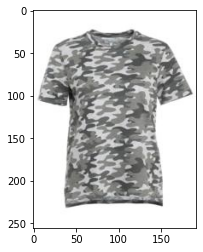

In [ ]:
%cd /content/drive/MyDrive/SMFAI/src

# maskRCNN
processCloth(raw_cloth_DIR, cloth_DIR, cloth_mask_DIR)
# CMU openPose https://github.com/CMU-Perceptual-Computing-Lab/openpose
getOpenPose(video, 0,4)
# show cloth
_=plt.imshow(cv.imread(os.path.join(cloth_DIR, \
                                    testPairsTxt(clothID, img_frames_DIR, cloth_DIR).iloc[0,1]))[:,:,::-1])

# https://github.com/GoGoDuck912/Self-Correction-Human-Parsing
%cd /content/drive/MyDrive/SMFAI/lib/humanParsing
!pip install ninja
!python parse.py --dataset 'pascal' \
--model-restore 'model_Schp_pascal.pth' \
--input-dir '../../data/processed/image' \
--output-dir 'pascal'

# read processed inputs
%cd /content/drive/MyDrive/SMFAI/src
getSCHP()
createSCHP_DIR(img_frames_DIR, parsed_img_DIR, image_mask_DIR)
readSCHP(parsed_img_DIR ,img_parse_new_DIR)

## try on - cp-vton-plus

In [ ]:
# warping
%cd /content/drive/MyDrive/SMFAI/src
tryOnInputGen(cpVtonPlusDIR)
%cd /content/drive/MyDrive/SMFAI/lib/cpVtonPlus
!pip install tensorboardX
!pip install torchvision==0.2.1
!python test.py --name 'GMM' \
--gpu_ids 'None' \
--batch-size 4 \
--dataroot 'data' \
--datamode 'test' \
--stage 'GMM' \
--data_list 'testPairs.txt' \

# move data
src_warp_cloth = 'result/GMM/test/warp-cloth'
src_warp_mask = 'result/GMM/test/warp-mask'
dest_warp_cloth = 'data/test/warp-cloth'
dest_warp_mask = 'data/test/warp-mask'
if os.path.exists(dest_warp_cloth):
    shutil.rmtree(dest_warp_cloth)
if os.path.exists(dest_warp_mask):
    shutil.rmtree(dest_warp_mask)
shutil.copytree(src_warp_cloth, dest_warp_cloth)
shutil.copytree(src_warp_mask, dest_warp_mask)

# try on
!python test.py \
--name TOM \
--stage TOM \
--workers 2 \
--datamode test \
--data_list testPairs.txt \
--checkpoint models/tom_final.pth

/content/drive/MyDrive/SMFAI/src
/content/drive/MyDrive/SMFAI/lib/cpVtonPlus
     |████████████████████████████████| 125 kB 10.8 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111


Namespace(batch_size=4, checkpoint='models/gmm_final.pth', data_list='testPairs.txt', datamode='test', dataroot='data', display_count=1, fine_height=256, fine_width=192, gpu_ids='None', grid_size=5, name='GMM', radius=5, result_dir='result', shuffle=False, stage='GMM', tensorboard_dir='tensorboard', workers=1)
Start to test stage: GMM, named: GMM!
initialization method [normal]
initialization method [normal]
step:        1, time: 8.429
step:        2, time: 5.570
step:        3, time: 5.680
step:        4, time: 5.837
step:        5, time: 5.815
step:        6, time: 5.787
step:        7, time: 5.750
step:        8, time: 5.739
step:        9, time: 5.489
step:       10, time: 4.384
Finished test GMM, named: GMM!
Namespace(batch_size=4, checkpoint='models/tom_final.pth', data_list='testPairs.txt', datamode='test', dataroot='data', display_count=1, fine_height=256, fine_width=192, gpu_ids='', grid_size=5, name='TOM', radius=5, result_dir='result', shuffle=False, stage='TOM', tensorboard

In [ ]:
#result
%cd /content/drive/MyDrive/SMFAI/src
out_video = getTryOnVideo(out_tryOn_DIR)
showColabVideo(out_video)

/content/drive/MyDrive/SMFAI/src
[MoviePy] >>>> Building video ../result/out_tryOnVideo_0.mp4
[MoviePy] Writing video ../result/out_tryOnVideo_0.mp4


100%|██████████| 40/40 [00:00<00:00, 117.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../result/out_tryOnVideo_0.mp4 

